In [2]:
# imports

# python packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.font_manager
import rpy2
from functools import reduce
import xarray as xr

# rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png
from rpy2.robjects import pandas2ri

# load rpy2 extension for ipython
pandas2ri.activate()
%load_ext rpy2.ipython

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.1
  warnings.warn(


In [3]:
# install & import r package sctransform

# check if sctransform is installed
if not ro.packages.isinstalled('sctransform'):
    # select CRAN mirror
    utils = importr('utils')
    utils.chooseCRANmirror(ind=1)
    # install sctransform
    utils.install_packages(ro.vectors.StrVector(['sctransform']))
    
# check if glmGamPoi is installed
if not ro.packages.isinstalled('glmGamPoi'):
    print('Please install glmGamPoi: https://github.com/const-ae/glmGamPoi')

# import sctransform
sctransform = importr('sctransform')
rmatrix = importr('Matrix')

# should be version 0.3.5 or higher                           
print(sctransform.__version__)


0.3.5


In [4]:
# helper functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount

# function to convert pandas dataframe to r matrix
def pandas_dataframe_to_r_matrix(df, dtype=float):
    """
    Function to convert pandas DataFrame objects to R matrix objects.
    """
    if dtype is float:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    elif dtype is str:
        vector = ro.vectors.StrVector(df.values.flatten().tolist())
    elif dtype is int:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    else:
        raise ValueError('The dtype {} is not recognized'.format(dtype))
    matrix = rmatrix.Matrix(
        data=vector, 
        nrow=df.shape[0], 
        ncol=df.shape[1], 
        byrow=True, 
        dimnames=[df.index.to_list(), df.columns.to_list()], 
        sparse=True
    )
    return matrix


# Read in collated mapping counts and metadata

In [5]:
# read in metadata

# filepaths
filepath_genome_metadata = '../../data/metadata/genome_metadata.csv'
filepath_ortholog_metadata = '../../data/metadata/ortholog_metadata.csv'
filepath_sample_metadata = '../../data/metadata/sample_metadata.csv'

# genome metadata
genome_df = pd.read_csv(filepath_genome_metadata)

#  ortholog metadata
ortholog_df = pd.read_csv(filepath_ortholog_metadata)

#  sample metadata
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})
sample_df['samplename'] = [name[:-2] for name in sample_df['SampleID']]
sample_df = sample_df.rename(columns={'SampleID': 'sample', 'Replicate': 'replicate'})

# create annotations_df to map annotations back to orthologs
annotations_df = ortholog_df[['OrthologID', 'Annotation']].drop_duplicates()
annotations_df = annotations_df.rename(columns={'OrthologID': 'ortholog', 'Annotation': 'annotation'})

sample_df


,sample,Cruise,Dataset,Experiment,Station,Cast,Datetime,Latitude,Longitude,Depth,replicate,SmallFraction,LargeFraction,Unfractionated,samplename
0,G3.DEPTH.NS.S6C7.130m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:36,32.92,-158.0,130,B,G3.DEPTH.NS.S6C7.130m.0_2um.B,NaN,True,G3.DEPTH.NS.S6C7.130m
1,G3.DEPTH.NS.S6C7.75m.A,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:40,32.92,-158.0,75,A,G3.DEPTH.NS.S6C7.75m.0_2um.A,NaN,True,G3.DEPTH.NS.S6C7.75m
2,G3.DEPTH.NS.S6C7.75m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:40,32.92,-158.0,75,B,G3.DEPTH.NS.S6C7.75m.0_2um.B,NaN,True,G3.DEPTH.NS.S6C7.75m
3,G3.DEPTH.NS.S6C7.15m.A,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:44,32.92,-158.0,15,A,G3.DEPTH.NS.S6C7.15m.0_2um.A,NaN,True,G3.DEPTH.NS.S6C7.15m
4,G3.DEPTH.NS.S6C7.15m.B,G3,Gradients 3 depth profile,NaN,6.0,7.0,4/22/19 6:44,32.92,-158.0,15,B,G3.DEPTH.NS.S6C7.15m.0_2um.B,NaN,True,G3.DEPTH.NS.S6C7.15m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,G2.REXP3.NS.LoNP.T96.A,G2,Resource ratio incubation,REXP3 T96 LoNP A,NaN,NaN,6/13/17 15:00,33.00,-158.0,15,A,G2.REXP3.NS.LoNP.T96.0_2um.A,G2.REXP3.NS.LoNP.T96.3um.A,False,G2.REXP3.NS.LoNP.T96
218,G2.REXP3.NS.LoNP.T96.C,G2,Resource ratio incubation,REXP3 T96 LoNP C,NaN,NaN,6/13/17 15:00,33.00,-158.0,15,C,G2.REXP3.NS.LoNP.T96.0_2um.C,G2.REXP3.NS.LoNP.T96.3um.C,False,G2.REXP3.NS.LoNP.T96
219,G2.REXP3.NS.NPFe.T96.A,G2,Resource ratio incubation,REXP3 T96 NPFe A,NaN,NaN,6/13/17 15:00,33.00,-158.0,15,A,G2.REXP3.NS.NPFe.T96.0_2um.A,G2.REXP3.NS.NPFe.T96.3um.A,False,G2.REXP3.NS.NPFe.T96
220,G2.REXP3.NS.NPFe.T96.B,G2,Resource ratio incubation,REXP3 T96 NPFe B,NaN,NaN,6/13/17 15:00,33.00,-158.0,15,B,G2.REXP3.NS.NPFe.T96.0_2um.B,G2.REXP3.NS.NPFe.T96.3um.B,False,G2.REXP3.NS.NPFe.T96


In [6]:
# read in mapped transcript abundance data

filepath_data = '../../data/2-mapping/collated_salmon_data.csv.gz'
mappings_df = pd.read_csv(filepath_data)
mappings_df


,MappingName,GeneLength,TPM,NumReads,SampleID,GenomeName,GeneID
0,AG-311-D23_2717613068,360,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613068
1,AG-311-D23_2717613069,114,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613069
2,AG-311-D23_2717613070,1083,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613070
3,AG-311-D23_2717613071,1053,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613071
4,AG-311-D23_2717613072,1080,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613072
...,...,...,...,...,...,...,...
216275059,W9_2553539569,447,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539569
216275060,W9_2553539570,249,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539570
216275061,W9_2553539571,324,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539571
216275062,W9_2553539572,483,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539572


# Process mapped reads

- Drop reference genes without ortholog mapping (hypothesized to mostly be rRNA & other highly conserved RNA)
- Within each clade in each sample, aggregate reads mapping to the same ortholog


In [7]:
# directory to store output
output_dir = '../../data/3-normalization'


In [8]:
# collect reads mapping to known orthologs only and aggregate within orthologs

pangenome_df = mappings_df[['MappingName', 'SampleID', 'GenomeName', 'NumReads', 'GeneLength']]

# add genus, clade, and ortholog info to dataframe
pangenome_df['Genus'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Genus'])
pangenome_df['Clade'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Clade'])
pangenome_df['OrthologID'] = pangenome_df['MappingName'].map(ortholog_df.set_index('MappingName')['OrthologID'])

# down-select to only the genes with an ortholog mapping
pangenome_df = pangenome_df[~pangenome_df['OrthologID'].isna()]

# aggregate all orthologs in same genus
pangenome_df = pangenome_df.groupby(['SampleID', 'Genus', 'Clade', 
                                  'OrthologID']).agg(Reads=('NumReads', 'sum')).reset_index()

# identify nonzero mappings (at least one read mapped to ortholog-sample-clade)
pangenome_df['Nonzero'] = pangenome_df['Reads'].gt(0.0)

pangenome_df


,SampleID,Genus,Clade,OrthologID,Reads,Nonzero
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000001.0,79.000,True
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000002.0,64.000,True
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000003.0,18.000,True
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000004.0,1583.802,True
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000005.0,814.674,True
...,...,...,...,...,...,...
21847903,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040282.0,0.000,False
21847904,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040288.0,0.000,False
21847905,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040290.0,0.000,False
21847906,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040293.0,0.000,False


# Separate out data by clade

In [11]:
# separate out data for most highly represented clades in dataset

# thresholds
detection_min = 3
coverage_threshold = 0.01
clades = {
    'pro': ['HLI', 'HLII', 'LLI'], 
    'syn': ['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-VII', 'CDR2']
}

# storage variables
ortho_list = []
sample_list = []
core_df_dict = {}

for selected_clade in clades['pro'] + clades['syn']:
    print(selected_clade)
    clade_pangenome_df = pangenome_df[pangenome_df.Clade == selected_clade]
    
    # make fresh directory
    dir_path = '{}/{}'.format(output_dir, selected_clade)
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    # down-select data to detected orthologs
    core_df = pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum())
    core_df = core_df[core_df.Nonzero.gt(0)]
#     core_df = core_df[core_df.Nonzero.ge(detection_min)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]

    # down-select to only samples with coverage that is at least x% of the max coverage found in the dataset
    coverage = clade_pangenome_df.groupby('SampleID').Nonzero.sum()
    max_cov = coverage.max()
    total_orthos = len(core_df.index)
    print('Max coverage: {} / {} orthologs ({})'.format(max_cov, total_orthos, max_cov/total_orthos))
    samples = coverage[coverage.gt(coverage.max() * coverage_threshold)].index
    sample_list.append(samples)
    min_cov = coverage[samples].min()
    print('Min coverage: {} / {} orthologs ({})'.format(min_cov, total_orthos, min_cov/total_orthos))
    print('Total samples: {}\n'.format(len(samples)))
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df['SampleID'].isin(samples)]
    
    # down-select data to only orthologs that show up in a minimum number of the remaining samples
    core_df = pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum())
    core_df = core_df[core_df.Nonzero.ge(detection_min)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]
    ortho_list.append(core_df.index)

    # pivot table
    clade_core_df = clade_pangenome_df.pivot(index='OrthologID', columns=['SampleID'], values='Reads')
    core_df_dict[selected_clade] = clade_core_df
    
    # save pre-normed data to csv
    clade_core_df.to_csv('{}/read_counts_{}.csv'.format(dir_path, selected_clade))
    

HLI
Max coverage: 2798 / 3843 orthologs (0.7280770231589904)
Min coverage: 28 / 3843 orthologs (0.007285974499089253)
Total samples: 175

HLII
Max coverage: 3418 / 4772 orthologs (0.7162615255658005)
Min coverage: 39 / 4772 orthologs (0.008172673931265717)
Total samples: 137

LLI
Max coverage: 3123 / 3587 orthologs (0.870643992194034)
Min coverage: 34 / 3587 orthologs (0.009478672985781991)
Total samples: 129

5.1A-I
Max coverage: 2569 / 3316 orthologs (0.7747285886610374)
Min coverage: 28 / 3316 orthologs (0.008443908323281062)
Total samples: 202

5.1A-II
Max coverage: 2940 / 3361 orthologs (0.8747396608152336)
Min coverage: 33 / 3361 orthologs (0.009818506396905683)
Total samples: 130

5.1A-III
Max coverage: 1881 / 2412 orthologs (0.7798507462686567)
Min coverage: 19 / 2412 orthologs (0.007877280265339967)
Total samples: 123

5.1A-IV
Max coverage: 3063 / 3390 orthologs (0.9035398230088496)
Min coverage: 32 / 3390 orthologs (0.00943952802359882)
Total samples: 207

5.1B-VII
Max covera

In [8]:
# look at intersections of samples and genes

# universal
print('Total cyanobacterial orthologs: {}'.format(len(reduce(np.union1d, ortho_list))))
print('Total cyanobacterial samples: {}'.format(len(reduce(np.union1d, sample_list))))
print('Shared cyanobacterial orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list))))
print('Shared cyanobacterial samples: {}\n'.format(len(reduce(np.intersect1d, sample_list))))

# pro
print('Total Pro orthologs: {}'.format(len(reduce(np.union1d, ortho_list[:3]))))
print('Total Pro samples: {}'.format(len(reduce(np.union1d, sample_list[:3]))))
print('Shared Pro orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[:3]))))
print('Shared Pro samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[:3]))))

# syn
print('Total Syn orthologs: {}'.format(len(reduce(np.union1d, ortho_list[3:]))))
print('Total Syn samples: {}'.format(len(reduce(np.union1d, sample_list[3:]))))
print('Shared Syn orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[3:]))))
print('Shared Syn samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[3:]))))


Total cyanobacterial orthologs: 10109
Total cyanobacterial samples: 222
Shared cyanobacterial orthologs: 1252
Shared cyanobacterial samples: 95

Total Pro orthologs: 5508
Total Pro samples: 178
Shared Pro orthologs: 1737
Shared Pro samples: 122

Total Syn orthologs: 6578
Total Syn samples: 222
Shared Syn orthologs: 1676
Shared Syn samples: 103



# Normalize data using sctransform

* Save diagnostic plots & csv files, as well as tensorized data in NetCDF4 format

pro
HLI


R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3254

R[write to console]: Total overdispersed genes: 3094

R[write to console]: Excluding 160 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3254 by 175

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3094 genes, 175 cells

R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=In

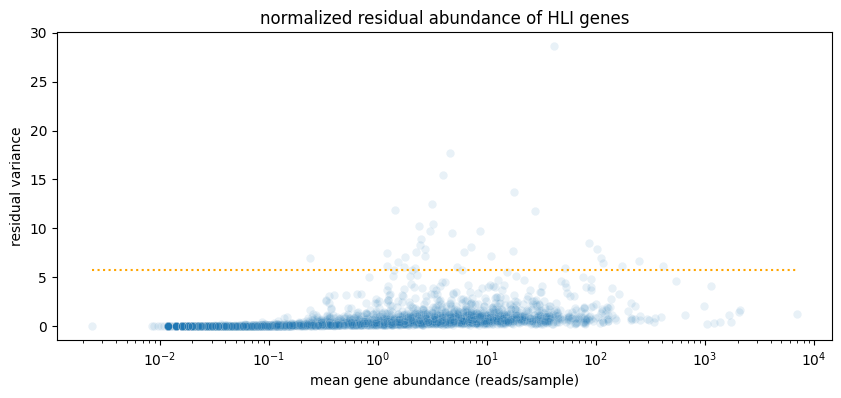

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3806

R[write to console]: Total overdispersed genes: 3600

R[write to console]: Excluding 206 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3806 by 137

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3600 genes, 137 cells



HLII


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 206

R[write to console]: Calling offset model for all 206 poisson genes

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 206 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.56

R[write to console]: Second step: Get residuals using fitted parameters for 3806 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.211192 secs



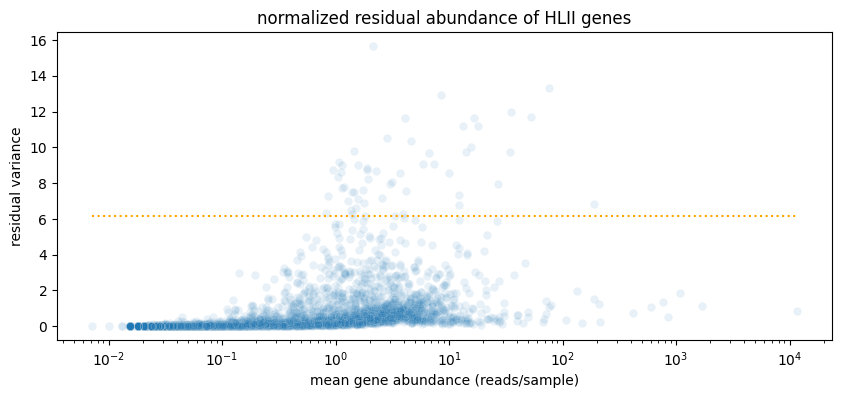

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2899

R[write to console]: Total overdispersed genes: 2818

R[write to console]: Excluding 81 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2899 by 129

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2818 genes, 129 cells



LLI


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 5

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 81

R[write to console]: Calling offset model for all 81 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 81 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2899 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.756568 secs



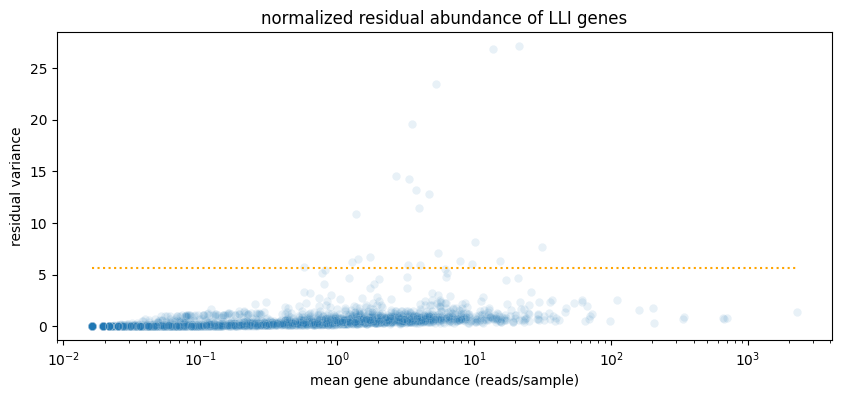

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2980

R[write to console]: Total overdispersed genes: 2876

R[write to console]: Excluding 104 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2980 by 202

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2876 genes, 202 cells



syn
5.1A-I


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 104

R[write to console]: Calling offset model for all 104 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 104 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2980 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.771991 secs



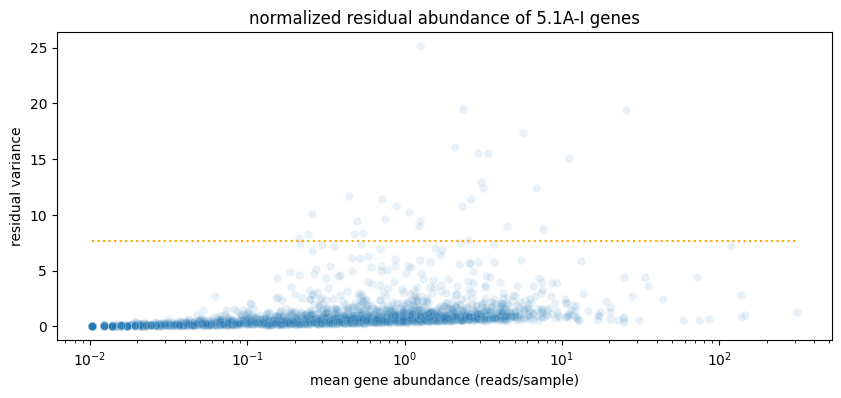

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3049

R[write to console]: Total overdispersed genes: 2982

R[write to console]: Excluding 67 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3049 by 130

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2982 genes, 130 cells



5.1A-II


R[write to console]: Setting estimate of  4 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 4

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 67

R[write to console]: Calling offset model for all 67 poisson genes

R[write to console]: Found 7 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 67 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 3049 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.797651 secs



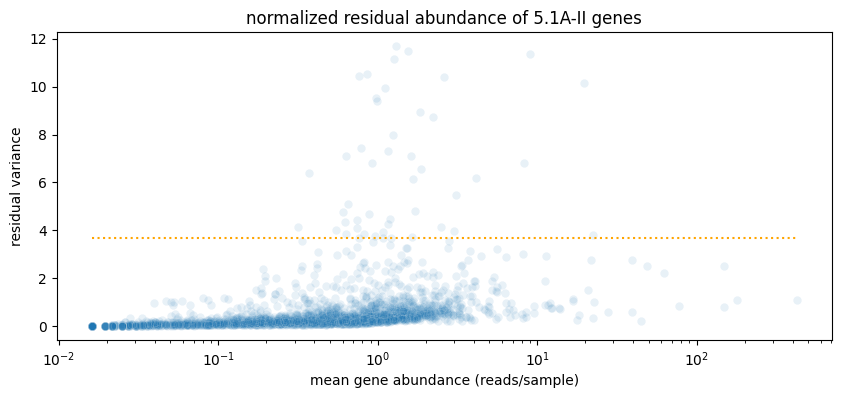

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2153

R[write to console]: Total overdispersed genes: 2062

R[write to console]: Excluding 91 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2153 by 123

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2062 genes, 123 cells



5.1A-III


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 3

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 91

R[write to console]: Calling offset model for all 91 poisson genes

R[write to console]: Found 5 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 91 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2153 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.21048 secs



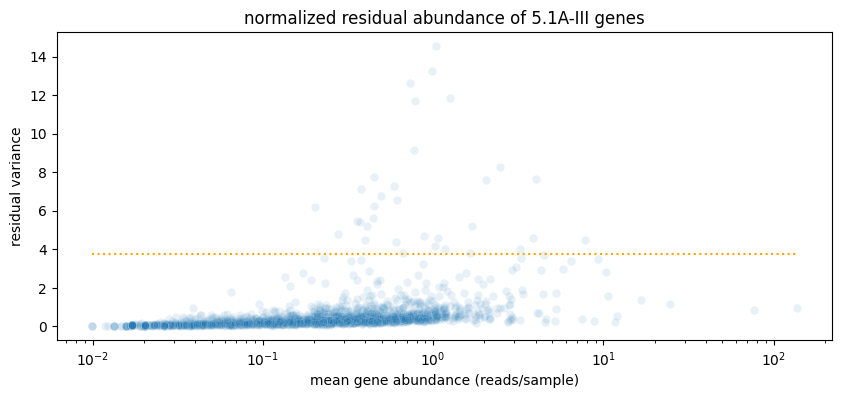

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3197

R[write to console]: Total overdispersed genes: 3133

R[write to console]: Excluding 64 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3197 by 207

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3133 genes, 207 cells



5.1A-IV


R[write to console]: Setting estimate of  10 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 10

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 64

R[write to console]: Calling offset model for all 64 poisson genes

R[write to console]: Found 20 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 64 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 3197 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.995082 secs



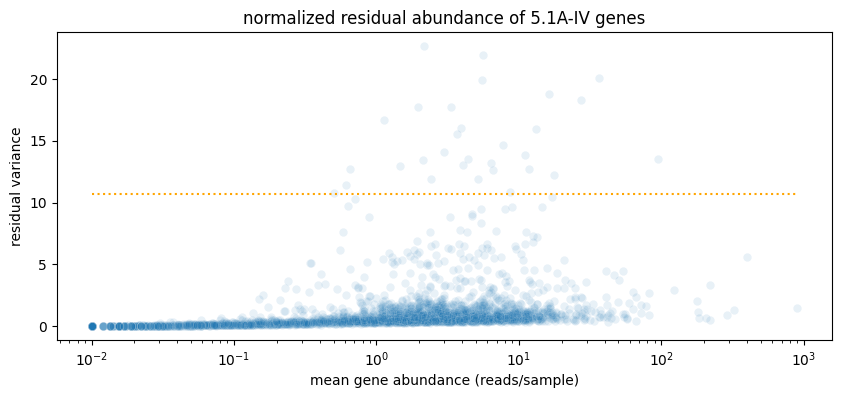

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3706

R[write to console]: Total overdispersed genes: 3603

R[write to console]: Excluding 103 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3706 by 151

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 3603 genes, 151 cells



5.1B-VII


R[write to console]: Setting estimate of  23 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 23

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 103

R[write to console]: Calling offset model for all 103 poisson genes

R[write to console]: Found 30 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 103 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 3706 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.252598 secs



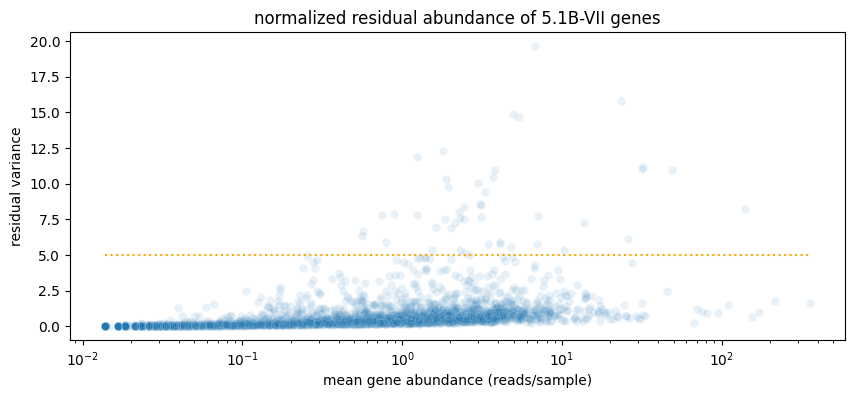

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3039

R[write to console]: Total overdispersed genes: 2955

R[write to console]: Excluding 84 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3039 by 143

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2955 genes, 143 cells



CDR2


R[write to console]: Setting estimate of  10 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 10

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 84

R[write to console]: Calling offset model for all 84 poisson genes

R[write to console]: Found 12 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 84 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 3039 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.845153 secs



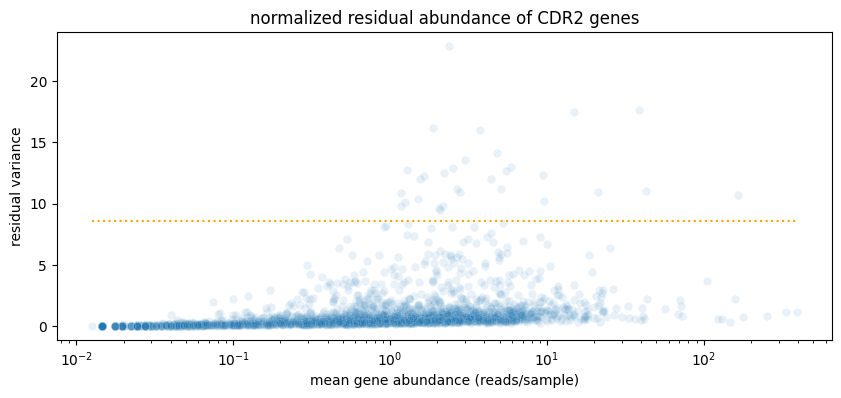

In [13]:
# run the model on each clade, saving outputs and plots

# store normalized data as slabs to arrange in xarray tensor
read_slabs = {}
residual_slabs = {}

# iterate through pro & syn
for genus in ['pro', 'syn']:
    print(genus)
    read_slabs[genus] = []
    residual_slabs[genus] = []
        
    # iterate through clades
    for clade in clades[genus]:
        print(clade)

        # make fresh directory
        dir_path = '{}/{}'.format(output_dir, clade)
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)

        # convert clade_core_df to r matrix
        clade_core_df = core_df_dict[clade]
        r_clade_core_df = pandas_dataframe_to_r_matrix(clade_core_df)

        # fit vst normalization model
        result = sctransform.vst(
            r_clade_core_df, 
            n_genes='null', 
            min_cells=detection_min,
            return_gene_attr=True, 
            return_cell_attr=True, 
            vst_flavor='v2', 
            verbosity=1
        )

        # save residuals as csv
        residual_df = pd.DataFrame(
            np.asarray(result[0]), 
            index=clade_core_df.index, 
            columns=clade_core_df.columns
        )
        residual_df.to_csv('{}/residuals_{}.csv'.format(dir_path, clade))
        
        # save residuals as slab 
        slab = (
            residual_df
            .reset_index()
            .rename(columns={'OrthologID': 'ortholog'})
            .melt(id_vars='ortholog', var_name='sample', value_name='residual')
        )
        slab['ortholog'] = slab['ortholog'].astype('Int64')
        slab['clade'] = clade
        residual_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))
        
        # save read counts as slab 
        slab = (
            clade_core_df
            .reset_index()
            .rename(columns={'OrthologID': 'ortholog'})
            .melt(id_vars='ortholog', var_name='sample', value_name='readcount')
        )
        slab['ortholog'] = slab['ortholog'].astype('Int64')
        slab['clade'] = clade
        read_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))

        # save plot of model parameters
        plots = sctransform.plot_model_pars(result, show_theta=True)
        img = image_png(plots)
        with open('{}/parameters_{}.png'.format(dir_path, clade), 'wb') as png:
            png.write(img.data)

        # plot high variance genes
        residual_var = residual_df.var(axis=1)
        three_sigma = 1 + residual_var.var() * 3
        expression = clade_core_df.apply(geometric_mean, axis=1)
        plt.figure(figsize=(10, 4))
        sns.scatterplot(x=expression, y=residual_var, alpha=0.1);
        plt.hlines(three_sigma, expression.min(), expression.max(), 
                   colors=['orange'], linestyles=[':'], label='3*sigma');
        plt.xlabel('mean gene abundance (reads/sample)')
        plt.xscale('log')
        plt.ylabel('residual variance')
        plt.title('normalized residual abundance of {} genes'.format(clade))
        plt.savefig('{}/residual_variance_{}.png'.format(dir_path, clade))
        plt.show()

        # save csv of residual variances with annotations
        res_var_df = residual_var.reset_index().rename(columns={0:'ResidualVariance'})
        res_var_df['Annotation'] = res_var_df.OrthologID.map(annotations_df.set_index('ortholog')['annotation'])
        res_var_df = res_var_df.sort_values('ResidualVariance', ascending=False).reset_index()
        res_var_df.to_csv('{}/high_variance_orthologs_{}.csv'.format(dir_path, clade))


In [14]:
# make slabs into xarray tensors and save

# make DataArrays for metadata
replicate_da = xr.DataArray.from_series(sample_df.set_index('sample')['replicate'])
samplename_da = xr.DataArray.from_series(sample_df.set_index('sample')['samplename'])
annotation_da = xr.DataArray.from_series(annotations_df.set_index('ortholog')['annotation'])

for genus in ['pro', 'syn']:
    # make read count DataArray
    read_data = read_slabs[genus]
    read_all_slabs = pd.concat(read_data)
    read_da = xr.DataArray.from_series(read_all_slabs['readcount']).fillna(0)
    # make residual DataArray
    residual_data = residual_slabs[genus]
    residual_all_slabs = pd.concat(residual_data)
    residual_da = xr.DataArray.from_series(residual_all_slabs['residual']).fillna(0)
    # combine residuals with metadata into xarray Dataset
    ds = xr.Dataset(
        dict(
            readcount=read_da, 
            residual=residual_da, 
            replicate=replicate_da.loc[residual_da.sample],
            samplename=samplename_da.loc[residual_da.sample], 
            annotation=annotation_da.loc[residual_da.ortholog]
        )
    )
    # save as netCDF4 file in data directory
    ds.to_netcdf('{}/{}-tensor-dataset.nc'.format(output_dir, genus))

ds
    

<xarray.Dataset>
Dimensions:     (ortholog: 6578, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) object 60000001 60000002 ... 60040245 60040289
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    residual    (ortholog, clade, sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    replicate   (sample) object 'A' 'B' 'C' 'A' 'B' 'C' ... 'B' 'C' 'A' 'B' 'C'
    samplename  (sample) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS.UW40_2.7m'
    annotation  (ortholog) object 'membrane protease FtsH catalytic subunit' ...

## Batch corrected normalization

As of February, 2023 this is not possible with the sctransform.vst function when using the "v2" version of the model (see [this issue](https://github.com/satijalab/sctransform/issues/126) for details). As the v2 version is the most appropriate for this data, batch correction is not possible at this time. Additionally, 
PCA and UMAP analysis of the data suggests that it may be difficult to disentangle batch effects from signal, since the batches are correlated with different sampling conditions.

In [ ]:
# # run the model on each clade, saving outputs and plots

# # store normalized data as slabs to arrange in xarray tensor
# slabs = {}
# # directory to store output
# output_dir = '../../data/3-normalization/batch-corrected'

# # iterate through pro & syn
# for genus in ['pro', 'syn']:
#     print(genus)
#     slabs[genus] = []
        
#     # iterate through clades
#     for clade in clades[genus]:
#         print(clade)

#         # make fresh directory
#         dir_path = '{}/{}'.format(output_dir, clade)
#         if not os.path.isdir(dir_path):
#             os.makedirs(dir_path)

#         # convert clade_core_df to r matrix
#         clade_core_df = core_df_dict[clade]
#         r_clade_core_df = pandas_dataframe_to_r_matrix(clade_core_df)
        
#         # pull out sample attributes that match samples in clade_core_df
#         sample_attr_df = sample_df.set_index('sample').loc[clade_core_df.columns, ['Dataset', 'Cruise']]
        
#         # convert pandas df to r dataframe
#         r_sample_attr_df = pandas2ri.py2rpy(sample_attr_df)

#         # fit vst normalization model
#         result = sctransform.vst(
#             r_clade_core_df, 
#             cell_attr=r_sample_attr_df, 
#             batch_var=ro.vectors.StrVector(["Dataset"]), 
#             n_genes='null', 
#             min_cells=detection_min,
#             return_gene_attr=True, 
#             return_cell_attr=True, 
# #             vst_flavor='v2', 
#             verbosity=10
#         )

#         # save residuals as csv
#         residual_df = pd.DataFrame(
#             np.asarray(result[0]), 
#             index=clade_core_df.index, 
#             columns=clade_core_df.columns
#         )
#         residual_df.to_csv('{}/residuals_{}.csv'.format(dir_path, clade))
        
#         # save residuals as slab 
#         slab = (
#             residual_df
#             .reset_index()
#             .rename(columns={'OrthologID': 'ortholog'})
#             .melt(id_vars='ortholog', var_name='sample', value_name='residual')
#         )
#         slab['ortholog'] = slab['ortholog'].astype('Int64')
#         slab['clade'] = clade
#         slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))

#         # save plot of model parameters
#         plots = sctransform.plot_model_pars(result, show_theta=True)
#         img = image_png(plots)
#         with open('{}/parameters_{}.png'.format(dir_path, clade), 'wb') as png:
#             png.write(img.data)

#         # plot high variance genes
#         residual_var = residual_df.var(axis=1)
#         three_sigma = 1 + residual_var.var() * 3
#         expression = clade_core_df.apply(geometric_mean, axis=1)
#         plt.figure(figsize=(10, 4))
#         sns.scatterplot(x=expression, y=residual_var, alpha=0.1);
#         plt.hlines(three_sigma, expression.min(), expression.max(), 
#                    colors=['orange'], linestyles=[':'], label='3*sigma');
#         plt.xlabel('mean gene abundance (reads/sample)')
#         plt.xscale('log')
#         plt.ylabel('residual variance')
#         plt.title('normalized residual abundance of {} genes'.format(clade))
#         plt.savefig('{}/residual_variance_{}.png'.format(dir_path, clade))
#         plt.show()

#         # save csv of residual variances with annotations
#         res_var_df = residual_var.reset_index().rename(columns={0:'ResidualVariance'})
#         res_var_df['Annotation'] = res_var_df.OrthologID.map(annotations_df.set_index('ortholog')['annotation'])
#         res_var_df = res_var_df.sort_values('ResidualVariance', ascending=False).reset_index()
#         res_var_df.to_csv('{}/high_variance_orthologs_{}.csv'.format(dir_path, clade))
        

In [ ]:
# # make slabs into xarray tensors and save

# # make DataArrays for metadata
# replicate_da = xr.DataArray.from_series(sample_df.set_index('sample')['replicate'])
# samplename_da = xr.DataArray.from_series(sample_df.set_index('sample')['samplename'])
# annotation_da = xr.DataArray.from_series(annotations_df.set_index('ortholog')['annotation'])

# for genus in ['pro', 'syn']:
#     # make residual DataArray
#     data = slabs[genus]
#     all_slabs = pd.concat(data)
#     residual_da = xr.DataArray.from_series(all_slabs['residual']).fillna(0)
#     # combine residuals with metadata into xarray Dataset
#     ds = xr.Dataset(
#         dict(
#             residual=residual_da, 
#             replicate=replicate_da,
#             samplename=samplename_da, 
#             annotation=annotation_da.loc[residual_da.ortholog]
#         )
#     )
#     # save as netCDF4 file in data directory
#     ds.to_netcdf('{}/{}-res-abun.nc'.format(output_dir, genus))

# ds
